In [448]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [668]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    sns.set(rc={'figure.figsize':(11.7,6.27)})
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
    sns.set_theme(style="ticks", palette="pastel")
    

set_style()

In [602]:
def parse_res(file):
    with open(file, 'r') as f:
        lines = f.read().split("\n")
        
    data = []
    for line in lines[1:]:
        if line:
            script, time = line.split()
            data.append([script.replace(".sh:", ""), float(time)])
    
    df = pd.DataFrame(data, columns=["test_name", "exec_time"])
    df = df.set_index("test_name")
    return df
parse_res('eval_results/run1/enabled_commutativity/oneliners/par.res')

,exec_time
test_name,
nfa-regex,3.384
sort,3.406
top-n,4.694
wf,11.530
spell,6.125
diff,9.175
bi-grams,6.689
set-diff,7.798
sort-sort,2.800


In [629]:
def plot_barchart_against(dfs, y_axis="speedup", test_names=None, title="", savefig=None):
#     
    summary = []
    for mode, df in dfs:
        df['mode'] = mode
        summary.append(df)
    
    summary_df = pd.concat(summary, axis = 0)
    
    ax = sns.barplot(x = 'benchmark', y = y_axis, data=summary_df, hue='mode')
#     ax.set_ylabel('speedup over Bash')
    plt.legend(loc='upper left')
    
    if savefig:
        plt.savefig(savefig)

In [623]:
def get_summary_df(all_dfs):
    summary = []
    for bench, dfs in all_dfs:
        for mode, df in dfs:
            df['benchmark'] = bench
            df['mode'] = mode
            summary.append(df)

    summary_df = pd.concat(summary, axis = 0)
    return summary_df

def boxplot(summary_df, x, y, savefig=None):
    if (len(summary_df.groupby('mode').mode.unique()) < 2):
        sns.boxplot( data=summary_df, x = 'benchmark', y = 'speedup')
    else:
        sns.boxplot( data=summary_df, x = 'benchmark', y = 'speedup', hue='mode')

        plt.legend(loc='upper right')
    if savefig:
        plt.savefig(savefig)

In [624]:
def average_dfs(dfs):
    df = pd.concat(dfs)
    df = df.groupby('test_name').mean()
    return df
    
def get_all_dfs(benchmarks, modes, runs):
    all_benchs = []
    for benchmark in benchmarks:
        dfs = []
        for mode in modes:
            df = average_dfs([parse_res(f'eval_results/{run}/{mode}/{benchmark}/par.res') for run in runs])
            dfs.append((mode.replace("_", " "), df))
            
        all_benchs.append((benchmark, dfs))
    return all_benchs

In [625]:
def get_speedup(baseline_df, dfs):
    speedups=[]
    for name, df in dfs:
        new_df = pd.DataFrame(index=df.index)
        new_df['speedup'] = baseline_df.exec_time/df.exec_time
        speedups.append((name, new_df))
        
    return speedups


                         speedup
mode                            
disabled commutativity  1.090622
enabled commutativity   1.504040


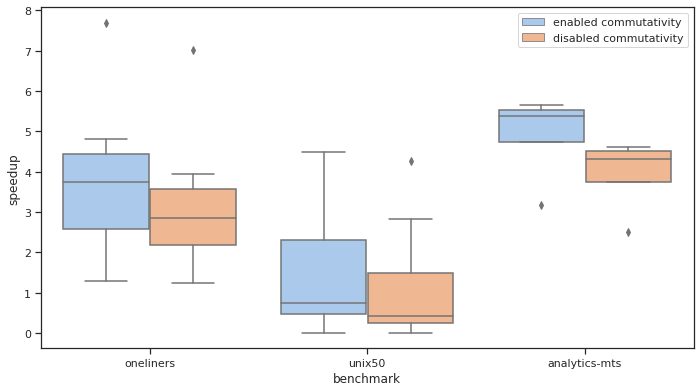

In [675]:
benchmarks = ["oneliners", "unix50", "analytics-mts"]
modes = ["enabled_commutativity", "disabled_commutativity" ]
runs = ['run1', 'run2', 'run3']

all_benchs = get_all_dfs(benchmarks, modes, runs)
#     plot_barchart_against(dfs, title=benchmark)
def pash_speedup_over_bash(all_benchs):
    speedups = []
    for benchmark, pash_dfs in all_benchs:
        bash_df = average_dfs([parse_res(f'eval_results/{run}/bash/{benchmark}/seq.res') for run in runs])
        speedups.append((benchmark, get_speedup(bash_df, pash_dfs)))
    summary_df = get_summary_df(speedups)
    return summary_df

def enabled_vs_disabled(all_benchs):
    speedups = []
    for benchmark, pash_dfs in all_benchs:
        assert(len(pash_dfs) == 2)
        if 'enabled' in pash_dfs[0][0]:
            enabled = pash_dfs[0]
            baseline_df = pash_dfs[1][1]
        else:
            enabled = pash_dfs[1]
            baseline_df = pash_dfs[0][1]
        speedups.append((benchmark, get_speedup(baseline_df, [enabled])))
    summary_df = get_summary_df(speedups)
    return summary_df



summary_df = pash_speedup_over_bash(all_benchs)
print(summary_df.groupby(['mode']).median())
boxplot(summary_df, x='benchmark', y='speedup', savefig="boxplot_speedup_over_bash_comm.pdf")




                        speedup benchmark
mode                                     
enabled commutativity  2.435317    unix50


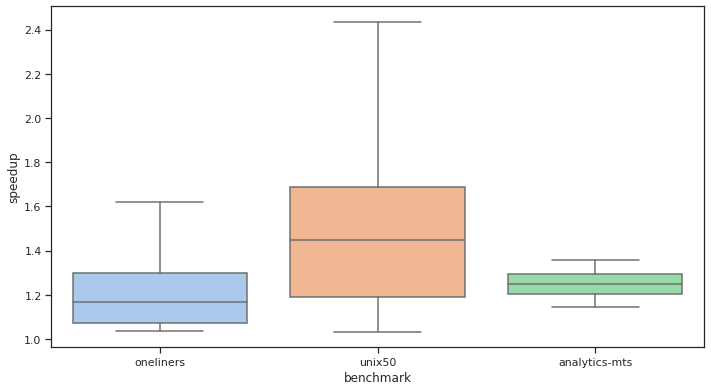

In [674]:
summary_df = enabled_vs_disabled(all_benchs)
print()
print(summary_df.groupby(['mode']).max())
boxplot(summary_df, x='benchmark', y='speedup', savefig='comm_speedup_over_pash.pdf')
# # print(all_benchs)

In [673]:
benchmarks = ["oneliners", "unix50", "analytics-mts", "max-temp"]
modes = ["enabled_commutativity", "disabled_commutativity" ]
runs = ['run1', 'run2', 'run3']

barplot_dfs = []
for mode in modes:
        one_mode_df = {
                'benchmark': [],
                'exec_time': []
            }
        for benchmark in benchmarks:
            bash_df = average_dfs([parse_res(f'eval_results/{run}/bash/{benchmark}/seq.res') for run in runs])
            df = average_dfs([parse_res(f'eval_results/{run}/{mode}/{benchmark}/par.res') for run in runs])
            speedup_df = get_speedup(bash_df, [(benchmark, df)])[0][1]
            one_mode_df['benchmark'].append(benchmark)
            one_mode_df['exec_time'].append(speedup_df.speedup.mean())
            
        barplot_dfs.append((mode, pd.DataFrame(one_mode_df)))

plot_barchart_against(barplot_dfs, savefig='barplot_speedup_comm.pdf')

ValueError: Could not interpret input 'speedup'

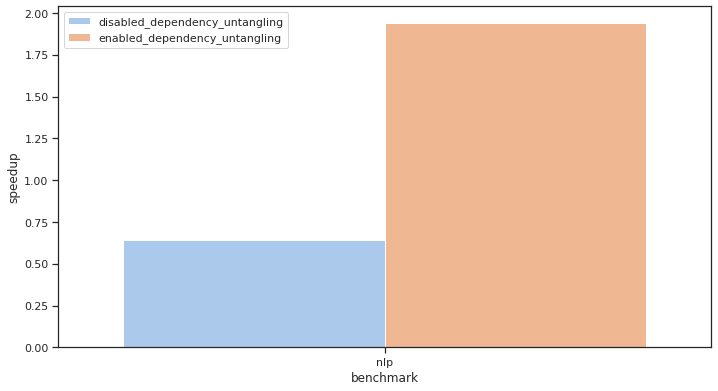

In [631]:
benchmarks = ["nlp"]
modes = ["disabled_dependency_untangling", "enabled_dependency_untangling" ]
runs = ['run1', 'run2', 'run3']

barplot_dfs = []
for mode in modes:
        one_mode_df = {
                'benchmark': [],
                'speedup': []
            }
        for benchmark in benchmarks:
            bash_df = average_dfs([parse_res(f'eval_results/{run}/bash/{benchmark}/seq.res') for run in runs])
            df = average_dfs([parse_res(f'eval_results/{run}/{mode}/{benchmark}/par.res') for run in runs])
            speedup_df = get_speedup(bash_df, [(benchmark, df)])[0][1]
            one_mode_df['benchmark'].append(benchmark)
            one_mode_df['speedup'].append(speedup_df.speedup.mean())
            
        barplot_dfs.append((mode, pd.DataFrame(one_mode_df)))


plot_barchart_against(barplot_dfs, title="", savefig='barplot_speedup_du_nlp.pdf')

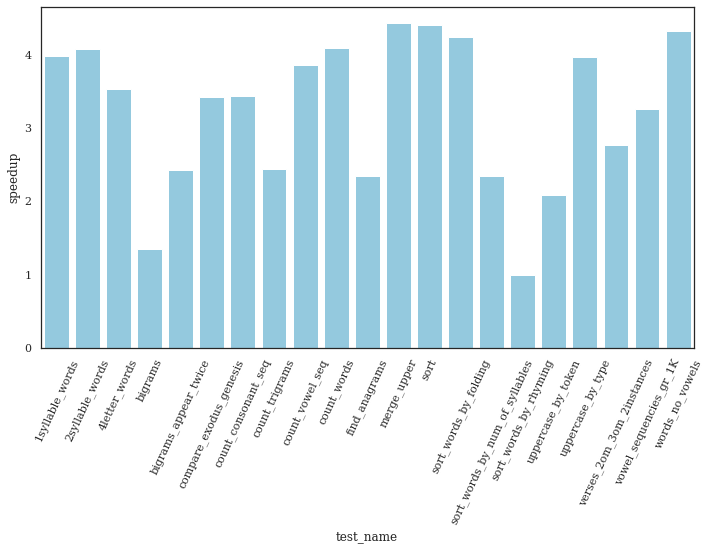

In [664]:
all_benchs = get_all_dfs(benchmarks, modes, runs)
summary_df = enabled_vs_disabled(all_benchs)
# print(summary_df.groupby(['mode', 'benchmark']).max())
# boxplot(summary_df, x='benchmark', y='speedup', savefig='boxplot_over_without_speedup_du.pdf
summary_df['test_name'] = summary_df.index
sns.barplot(data=summary_df, x = 'test_name', y = 'speedup', color='skyblue')
plt.xticks(rotation=65)
plt.savefig("barplot_du_over_without.pdf", bbox_inches='tight')

                                           speedup
mode                           benchmark          
disabled dependency untangling nlp        0.643593
enabled dependency untangling  nlp        1.941842


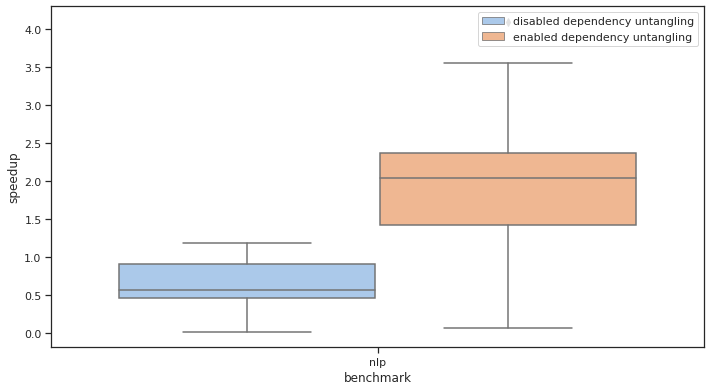

In [670]:
all_benchs = get_all_dfs(benchmarks, modes, runs)
summary_df = pash_speedup_over_bash(all_benchs)
print(summary_df.groupby(['mode', 'benchmark']).mean())
boxplot(summary_df, x='benchmark', y='speedup', savefig='boxplot_over_pash_speedup_du.pdf')

In [ ]:
.